#**Практическое задание №1**

Установка необходимых пакетов:

In [195]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [196]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [197]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [198]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [199]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        # Путь к файлу, скачанному вручную
        file_path = f"{name}.npz"  # Обновите путь, если файл в другой директории
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dataset file {file_path} not found!")

        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(file_path)
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        return self.image(i), self.labels[i]


### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 7.
Label code corresponds to STR class.


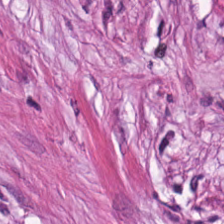

In [200]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [201]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'

        # Log the types of elements to debug
        print(f"Types of gt elements: {[type(i) for i in gt]}")
        print(f"Types of pred elements: {[type(i) for i in pred]}")

        return sum(int(i == j) for i, j in zip(gt, pred)) / len(gt)


    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [214]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import os
import gdown

class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()

        # Сверточные слои
        self.conv1 = layers.Conv2D(32, (3, 3), padding='same')
        self.bn1 = layers.BatchNormalization()
        self.pool = layers.MaxPooling2D(pool_size=(2, 2))

        self.conv2 = layers.Conv2D(64, (3, 3), padding='same')
        self.bn2 = layers.BatchNormalization()

        self.conv3 = layers.Conv2D(128, (3, 3), padding='same')
        self.bn3 = layers.BatchNormalization()

        self.conv4 = layers.Conv2D(256, (3, 3), padding='same')
        self.bn4 = layers.BatchNormalization()

        self.conv5 = layers.Conv2D(256, (3, 3), padding='same')
        self.bn5 = layers.BatchNormalization()

        self.conv6 = layers.Conv2D(512, (3, 3), padding='same')
        self.bn6 = layers.BatchNormalization()

        self.conv7 = layers.Conv2D(512, (3, 3), padding='same')
        self.bn7 = layers.BatchNormalization()

        # Глобальный слой агрегации
        self.global_pool = layers.GlobalAveragePooling2D()

        # Полносвязные слои
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(64, activation='relu')
        self.fc3 = layers.Dense(9, activation='softmax')  # Количество классов - 9

        self.dropout = layers.Dropout(0.5)

    def call(self, x):
        x = self.pool(self.bn1(self.conv1(x)))
        x = self.pool(self.bn2(self.conv2(x)))
        x = self.pool(self.bn3(self.conv3(x)))
        x = self.pool(self.bn4(self.conv4(x)))
        x = self.pool(self.bn5(self.conv5(x)))
        x = self.pool(self.bn6(self.conv6(x)))
        x = self.bn7(self.conv7(x))

        x = self.global_pool(x)

        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    def save(self, name):
        save_path = f"/content/drive/MyDrive/DP/{name}.weights.h5"
        self.save_weights(save_path)
        print(f"Model saved to {save_path}")

    def load(self, name):
        load_path = f"/content/drive/MyDrive/DP/{name}.weights.h5"
        self.load_weights(load_path)
        print(f"Model loaded from {load_path}")

    def normalize_inputs(self, images, mean, std):
        mean = np.array(mean).reshape(1, 1, 1, -1)  # Преобразуем mean в формат (1, 1, 1, C)
        std = np.array(std).reshape(1, 1, 1, -1)    # Преобразуем std в формат (1, 1, 1, C)

        normalized_images = (images - mean) / std
        return normalized_images

    def train_model(self, dataset, batch_size=32, num_epochs=60, learning_rate=0.001):
        # Используем SparseCategoricalCrossentropy для многоклассовой классификации
        criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        optimizer = optimizers.Adam(learning_rate=learning_rate)

        loss_list = []

        for epoch in range(num_epochs):
            epoch_loss = 0.0
            n_batches = dataset.n_files // batch_size

            for _ in tqdm(range(n_batches), desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = dataset.random_batch_with_labels(batch_size)
                inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
                labels = tf.convert_to_tensor(labels, dtype=tf.int32)

                with tf.GradientTape() as tape:
                    predictions = self(inputs, training=True)
                    loss = criterion(labels, predictions)

                gradients = tape.gradient(loss, self.trainable_variables)
                optimizer.apply_gradients(zip(gradients, self.trainable_variables))

                epoch_loss += loss.numpy()

            loss_list.append(epoch_loss / n_batches)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / n_batches:.4f}")

        return loss_list, num_epochs

    def test_on_dataset(self, dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)

        for img in dataset.images_seq(n):
            img = np.expand_dims(img, axis=0)  # (H, W, C) -> (1, H, W, C)
            img = self.normalize_inputs(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            pred = self(img)
            predictions.append(np.argmax(pred, axis=1)[0])

        return predictions

    def test_on_image(self, img: np.ndarray):
        img = np.expand_dims(img, axis=0)  # (H, W, C) -> (1, H, W, C)
        img = self.normalize_inputs(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        pred = self(img)
        return np.argmax(pred, axis=1)[0]


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [204]:
d_train = Dataset('train_small')
d_test = Dataset('test_small')


Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.
Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


In [215]:
model = Model()
if not EVALUATE_ONLY:
    loss_list, num_epochs = model.train_model(d_train)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

Epoch 1/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1/60], Loss: 69.4934


Epoch 2/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2/60], Loss: 1.2648


Epoch 3/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3/60], Loss: 1.1265


Epoch 4/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [4/60], Loss: 1.1652


Epoch 5/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [5/60], Loss: 1.0513


Epoch 6/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [6/60], Loss: 0.9475


Epoch 7/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [7/60], Loss: 0.8638


Epoch 8/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [8/60], Loss: 0.9300


Epoch 9/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [9/60], Loss: 0.8196


Epoch 10/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [10/60], Loss: 0.7574


Epoch 11/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [11/60], Loss: 0.6888


Epoch 12/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [12/60], Loss: 0.6857


Epoch 13/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [13/60], Loss: 0.7257


Epoch 14/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [14/60], Loss: 0.5525


Epoch 15/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [15/60], Loss: 0.5114


Epoch 16/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [16/60], Loss: 0.4889


Epoch 17/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [17/60], Loss: 0.4217


Epoch 18/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [18/60], Loss: 0.3131


Epoch 19/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [19/60], Loss: 0.3511


Epoch 20/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [20/60], Loss: 0.3698


Epoch 21/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [21/60], Loss: 0.2422


Epoch 22/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [22/60], Loss: 0.2205


Epoch 23/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [23/60], Loss: 0.1682


Epoch 24/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [24/60], Loss: 0.1676


Epoch 25/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [25/60], Loss: 376969.0628


Epoch 26/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [26/60], Loss: 449.2728


Epoch 27/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [27/60], Loss: 75.5000


Epoch 28/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [28/60], Loss: 28.4157


Epoch 29/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [29/60], Loss: 19.4238


Epoch 30/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [30/60], Loss: 16.5868


Epoch 31/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [31/60], Loss: 14.2974


Epoch 32/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [32/60], Loss: 12.5823


Epoch 33/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [33/60], Loss: 10.7924


Epoch 34/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [34/60], Loss: 10.4581


Epoch 35/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [35/60], Loss: 9.4886


Epoch 36/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [36/60], Loss: 8.7622


Epoch 37/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [37/60], Loss: 7.2543


Epoch 38/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [38/60], Loss: 9.0796


Epoch 39/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [39/60], Loss: 7.5605


Epoch 40/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [40/60], Loss: 7.1056


Epoch 41/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [41/60], Loss: 7.2199


Epoch 42/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [42/60], Loss: 7.0260


Epoch 43/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [43/60], Loss: 7.3247


Epoch 44/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [44/60], Loss: 6.5332


Epoch 45/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [45/60], Loss: 7.5835


Epoch 46/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [46/60], Loss: 5.1581


Epoch 47/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [47/60], Loss: 10.5083


Epoch 48/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [48/60], Loss: 4.8728


Epoch 49/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [49/60], Loss: 7.8001


Epoch 50/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [50/60], Loss: 41.6790


Epoch 51/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [51/60], Loss: 2.2560


Epoch 52/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [52/60], Loss: 2.2377


Epoch 53/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [53/60], Loss: 2.2245


Epoch 54/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [54/60], Loss: 2.2131


Epoch 55/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [55/60], Loss: 2.2045


Epoch 56/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [56/60], Loss: 2.2016


Epoch 57/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [57/60], Loss: 2.2025


Epoch 58/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [58/60], Loss: 2.1985


Epoch 59/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [59/60], Loss: 2.1974


Epoch 60/60:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch [60/60], Loss: 2.1973
Model saved to /content/drive/MyDrive/DP/best.weights.h5


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Пример тестирования модели на части набора данных:

In [6]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

NameError: name 'model' is not defined

Пример тестирования модели на полном наборе данных:

In [4]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

NameError: name 'TEST_ON_LARGE_DATASET' is not defined

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [209]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Model loaded from /content/drive/MyDrive/DP/best.weights.h5


FileNotFoundError: Dataset file test_tiny.npz not found!

Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"